<div class="alert alert-block alert-success">
<h1>Convex Optimization Project #3<h1>
Amin Abdipour 401133011</h1>
</div>

# 1. Classify MNIST Dataset with AdaGrad Optimizer

### Define MyAdaGrad

In [ ]:
import torch
import torch.nn as nn

class MyAdaGrad(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        defaults = dict(lr=lr, eps=eps)
        super(MyAdaGrad, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if 'sum' not in state:
                    state['sum'] = torch.zeros_like(p.data)

                # Update parameter
                state['sum'] += grad * grad
                p.data -= group['lr'] * grad / torch.sqrt(state['sum'] + group['eps'])


In [ ]:
import torchvision
import matplotlib.pyplot as plt


### Load MNIST dataset

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

### Define Network

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = MyNet()
optimizer = MyAdaGrad(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

### Train

In [ ]:
loss_values = []

for epoch in range(13):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_values.append(loss.item())

        # Print the loss
    print(f'Epoch [{epoch + 1}/{13}], Loss: {loss.item()}')

Epoch [1/13], Loss: 0.11706620454788208
Epoch [2/13], Loss: 0.12361029535531998
Epoch [3/13], Loss: 0.16614530980587006
Epoch [4/13], Loss: 0.3653718829154968
Epoch [5/13], Loss: 0.13930125534534454
Epoch [6/13], Loss: 0.2970641553401947
Epoch [7/13], Loss: 0.04161188751459122
Epoch [8/13], Loss: 0.11605389416217804
Epoch [9/13], Loss: 0.11594254523515701
Epoch [10/13], Loss: 0.12408453226089478
Epoch [11/13], Loss: 0.12207959592342377
Epoch [12/13], Loss: 0.13916558027267456
Epoch [13/13], Loss: 0.04057576134800911


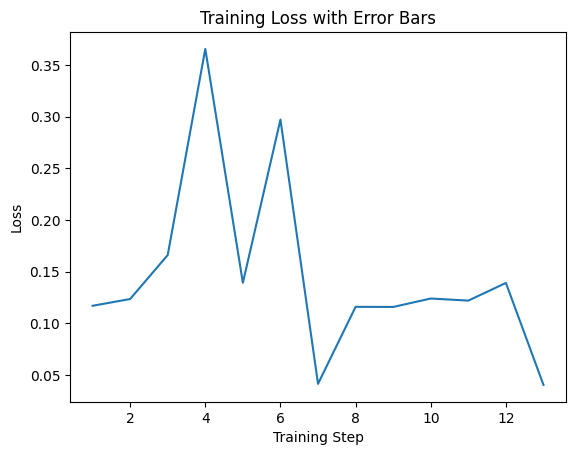

In [ ]:
from matplotlib import pyplot as plt
plt.errorbar(range(1, len(loss_values) + 1), loss_values, fmt='-', yerr=None, ecolor='red', capsize=5)
plt.title('Training Loss with Error Bars')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

### Test Model

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')


Test Accuracy: 96.17%


# 2. Implement Barrier Method

### Barrier Method

In [ ]:
import numpy as np
from scipy.optimize import minimize
def barrier_method(A, b, P, q, x0, mu, tol=1e-6, max_iter=10):

    m, n = P.shape
    x = x0
    t = 1
    primal_objective_values = []
    dual_objective_values = []
    mmm = 0;
    for _ in range(max_iter):
        print(mmm)
        mmm = mmm+1

        def obj_func(x):
            obj_value = 0.5 * sum(np.dot(x, np.dot(A[i], x)) for i in range(len(A))) - np.dot(b, x)
            barrier_value = -sum(np.log(q - np.dot(P, x)))
            return obj_value + mu * barrier_value

        def jac_func(x):
            grad_obj = sum(np.dot(A[i], x) for i in range(len(A))) - b
            grad_barrier = sum(P[j] / (q[j] - np.dot(P[j], x)) for j in range(len(q)))
            return grad_obj + mu * grad_barrier

        # Minimize the objective function using scipy's minimize function
        res = minimize(obj_func, x, jac=jac_func, method='Newton-CG', tol=tol)
        x = res.x

        # Compute primal and dual objective values
        primal_value = 0.5 * sum(np.dot(x, np.dot(A[i], x)) for i in range(len(A))) - np.dot(b, x)
        dual_value = np.dot(q, res.x) - np.sum(np.log(np.maximum(q - np.dot(P, x), 1e-15)))  # Avoiding taking log of non-positive values

        primal_objective_values.append(primal_value)
        dual_objective_values.append(dual_value)

        # Check for convergence
        if np.linalg.norm(np.dot(P, x) - q) < tol:
            break

        # Increase the barrier parameter
        mu *= t
        t *= 2

    return x, primal_objective_values, dual_objective_values


### Plot duality gap for different values of mu

In [ ]:
def tridiag(n):
    diag = 4 * np.eye(n)
    off_diag = -1 * np.eye(n - 1)
    return diag + np.diag(-1 * np.ones(n - 1), k=1) + np.diag(-1 * np.ones(n - 1), k=-1)

#### n=100

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2
3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4
5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))


5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2
3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

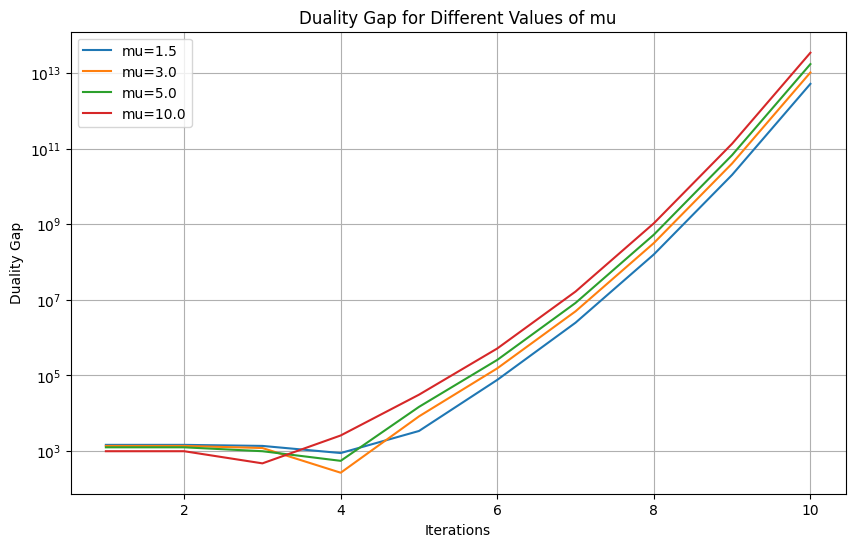

In [ ]:

# Define problem parameters
n = 100
A_1 = tridiag(n)
A_2 = np.fromfunction(lambda i, j: 1 / (i + j + 1), (n, n), dtype=float)
b = np.ones(n)
P = np.random.randn(n, n)
q = np.random.randn(n)

# Initial guess for optimization variables
x0 = np.zeros(n)

# Values of mu for which to plot the duality gap
mus = [1.5, 3., 5., 10.]

# Plot duality gap for different values of mu
plt.figure(figsize=(10, 6))
for mu in mus:
    _, primal_values, dual_values = barrier_method([A_1, A_2], b, P, q, x0, mu=mu)
    iterations = np.arange(1, len(primal_values) + 1)
    duality_gap = np.abs(np.array(primal_values) - np.array(dual_values))
    plt.plot(iterations, duality_gap, label=f'mu={mu}')

plt.xlabel('Iterations')
plt.ylabel('Duality Gap')
plt.title('Duality Gap for Different Values of mu')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


#### n=400

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

0


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

1
2


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

3


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

4


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

5


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

6


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

7


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

8


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

9


<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value encountered in log
  barrier_value = -sum(np.log(q - np.dot(P, x)))
<ipython-input-9-e8293c54ab85>:34: RuntimeWarning: invalid value enco

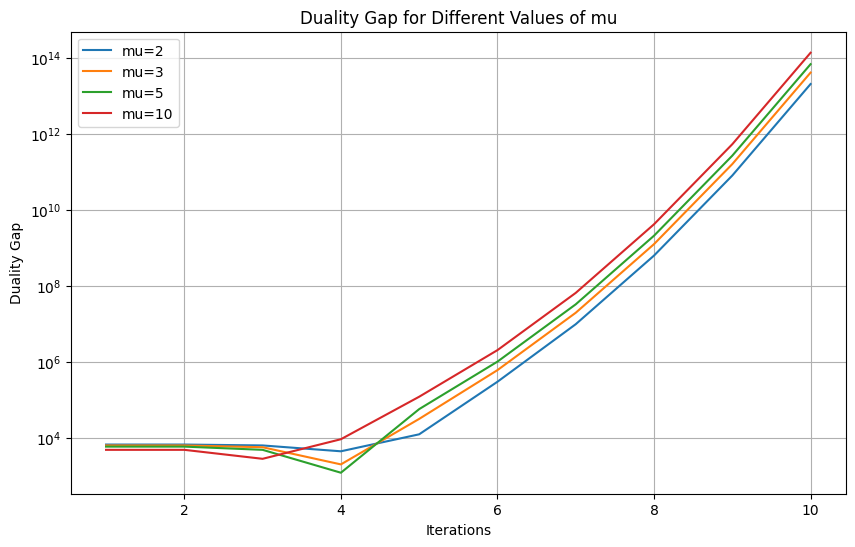

In [ ]:

# Define problem parameters
n = 400
A_1 = tridiag(n)
A_2 = np.fromfunction(lambda i, j: 1 / (i + j + 1), (n, n), dtype=float)
b = np.ones(n)
P = np.random.randn(n, n)
q = np.random.randn(n)

# Initial guess for optimization variables
x0 = np.zeros(n)

# Values of mu for which to plot the duality gap
mus = [1.5, 3., 5., 10.]

# Plot duality gap for different values of mu
plt.figure(figsize=(10, 6))
for mu in mus:
    _, primal_values, dual_values = barrier_method([A_1, A_2], b, P, q, x0, mu=mu)
    iterations = np.arange(1, len(primal_values) + 1)
    duality_gap = np.abs(np.array(primal_values) - np.array(dual_values))
    plt.plot(iterations, duality_gap, label=f'mu={round(mu)}')

plt.xlabel('Iterations')
plt.ylabel('Duality Gap')
plt.title('Duality Gap for Different Values of mu')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


# 3. Primal-dual interior-point Method

In [ ]:
from scipy.linalg import block_diag
from scipy.optimize import minimize_scalar


def pdip_method(A, b, P, q, x0, mu=1, tol=1e-6, max_iter=100):

    m, n = P.shape
    x = x0
    s = np.ones(m)
    y = np.ones(n)
    t = 1

    surrogate_duality_gap = []
    r_feas = []

    for _ in range(max_iter):
        # Define the KKT matrix
        H = block_diag(*A) + np.diag(mu * s**(-2))
        P_tilde = np.concatenate((P, np.zeros((m, n))), axis=1)  # Augment P with zeros to match dimensions for concatenation
        K = np.block([[H, P_tilde.T], [P_tilde, np.zeros((m, m))]])

        # Define the residual vectors
        r_pri = np.dot(P, x) - q
        r_dual_accum = sum(np.dot(A[i], x) for i in range(len(A)))  # Accumulate dot products individually
        r_dual = r_dual_accum - b - s  # Subtract only the first n elements of s

        # Compute r_feas
        r_feas_val = np.linalg.norm(np.concatenate((r_pri, r_dual)))
        r_feas.append(r_feas_val)

        # Compute the surrogate duality gap
        surrogate_duality_gap.append(np.dot(b, x))

        # Check for convergence
        if r_feas_val < tol:
            break

        # Construct the KKT system
        rhs = np.concatenate((r_dual, -r_pri))  # Reorder

        # Solve the linear system using scipy's solve function
        print(r_dual.shape)
        print((-r_pri).shape)
        delta_aff = np.linalg.solve(K[:300], rhs)

        # Compute the step lengths
        alpha_aff_pri = np.min(np.where(delta_aff[:n] < 0, -x / delta_aff[:n], np.inf))
        alpha_aff_dual = np.min(np.where(delta_aff[n:] < 0, -s / delta_aff[n:], np.inf))
        alpha_aff = min(alpha_aff_pri, alpha_aff_dual)

        # Compute the centering parameter
        sigma = (np.dot(r_pri, r_dual) / (np.dot(s, x)))

        # Define the predictor-corrector system
        delta = delta_aff + sigma * np.ones(len(delta_aff))

        # Compute the step lengths for the corrector step
        alpha_pri = np.min(np.where(delta[:n] < 0, -x / delta[:n], np.inf))
        alpha_dual = np.min(np.where(delta[n:-m] < 0, -s / delta[n:-m], np.inf))
        alpha = min(alpha_pri, alpha_dual)

        # Update the variables
        x += alpha * delta[:n]
        y += alpha * delta[n:-m]
        s += alpha * delta[-m:]

        # Update the barrier parameter
        mu *= t
        t *= 2

    return x, surrogate_duality_gap, r_feas



#### n = 100

In [ ]:

# Define problem parameters
n = 100
A = [tridiag(n), np.linalg.inv(np.vander(np.arange(1, n + 1)))]  # A_1 and A_2 matrices
b = np.ones(n)  # Vector b with all elements 1
P = np.random.randn(n, n)  # Random matrix P
q = np.random.randn(n)  # Random vector q
x0 = np.zeros(n)  # Initial guess for optimization variables
mu = 10  # Barrier parameter

# Solve the optimization problem using the Primal-Dual Interior-Point method
x_opt, surrogate_duality_gap, r_feas = pdip_method(A, b, P, q, x0, mu=mu)

# Plot surrogate duality gap and r_feas
plt.figure(figsize=(10, 6))
plt.plot(surrogate_duality_gap, label='Surrogate Duality Gap')
plt.plot(r_feas, label='r_feas')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Surrogate Duality Gap and r_feas')
plt.legend()
plt.grid(True)
plt.show()


#### n = 400

In [ ]:

# Define problem parameters
n = 100
A = [tridiag(n), np.linalg.inv(np.vander(np.arange(1, n + 1)))]  # A_1 and A_2 matrices
b = np.ones(n)  # Vector b with all elements 1
P = np.random.randn(n, n)  # Random matrix P
q = np.random.randn(n)  # Random vector q
x0 = np.zeros(n)  # Initial guess for optimization variables
mu = 10  # Barrier parameter

# Solve the optimization problem using the Primal-Dual Interior-Point method
x_opt, surrogate_duality_gap, r_feas = pdip_method(A, b, P, q, x0, mu=mu)

# Plot surrogate duality gap and r_feas
plt.figure(figsize=(10, 6))
plt.plot(surrogate_duality_gap, label='Surrogate Duality Gap')
plt.plot(r_feas, label='r_feas')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Surrogate Duality Gap and r_feas')
plt.legend()
plt.grid(True)
plt.show()


#### Chat GPT code

In [ ]:
def tridiag(n):
    diag = 4 * np.eye(n)
    off_diag = -1 * np.eye(n - 1)
    return diag + np.diag(-1 * np.ones(n - 1), k=1) + np.diag(-1 * np.ones(n - 1), k=-1)

def hilbert(n):
    return np.fromfunction(lambda i, j: 1 / (i + j + 1), (n, n), dtype=float)

def constraints(x, P, q):
    return np.dot(P, x) - q

def r_pri(x, A, b, P, q):
    return np.concatenate((np.dot(A[0], x) - b, constraints(x, P, q)))

def r_dual(x, A, P):
    return np.concatenate((np.dot(A[0], x), np.zeros_like(constraints(x, P, q))))

def r_feas(x, A, b, P, q):
    r_p = np.dot(A[0], x) - b
    r_d = constraints(x, P, q)
    return np.sqrt(np.sum(r_p**2) + np.sum(r_d**2))

def phi_mu(x, A, b, P, q, mu):
    r_p = np.dot(A[0], x) - b
    r_d = constraints(x, P, q)
    return objective_function(x, A[0], b) - np.sum(np.log(-r_d)) - np.sum(np.log(-r_p)) - mu * np.sum(np.log(x))

def jacobian(x, A, P):
    grad_obj = np.dot(A[0], x)
    grad_barrier = P / constraints(x, P, q)[:, np.newaxis]  # Ensure broadcasting
    return np.vstack((grad_obj, grad_barrier))

def solve_newton_system(x, A, b, P, q, mu):
    r_p = np.dot(A[0], x) - b
    r_d = constraints(x, P, q)
    F = np.concatenate((r_p, r_d)).reshape(-1, 1)  # Reshape F to be a column vector
    J = jacobian(x, A, P)
    delta_x = np.linalg.pinv(J) @ (-F)  # Using pseudo-inverse to solve the system
    return delta_x[:len(x)]


def primal_dual_interior_point(A, b, P, q, x0, mu=10, tol=1e-6, max_iter=100):
    x = x0
    primal_objective_values = []
    surrogate_duality_gap = []
    r_feas_values = []

    for _ in range(max_iter):
        r_pri_norm = np.linalg.norm(r_pri(x, A, b, P, q))
        r_dual_norm = np.linalg.norm(r_dual(x, A, P))
        surrogate_gap = phi_mu(x, A, b, P, q, mu)
        r_feas_val = r_feas(x, A, b, P, q)

        primal_objective_values.append(objective_function(x, A[0], b))
        surrogate_duality_gap.append(surrogate_gap)
        r_feas_values.append(r_feas_val)

        if r_pri_norm < tol and r_dual_norm < tol:
            break

        delta_x = solve_newton_system(x, A, b, P, q, mu)
        x += delta_x

    return x, primal_objective_values, surrogate_duality_gap, r_feas_values

# Define problem parameters
n = 100
A_1 = tridiag(n)
A_2 = hilbert(n)
b = np.ones(n)
P = np.random.randn(n, n)
q = np.random.randn(n)
x0 = np.zeros(n)

# Solve the problem using primal-dual interior-point method
x_opt, primal_values, surrogate_gap, r_feas_values = primal_dual_interior_point([A_1, A_2], b, P, q, x0, mu=10)

# Plot surrogate duality gap and r_feas over iterations
iterations = range(1, len(primal_values) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(iterations, surrogate_gap, label='Surrogate Duality Gap')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Surrogate Duality Gap')
plt.title('Surrogate Duality Gap over Iterations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iterations, r_feas_values, label='r_feas')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('r_feas')
plt.title('r_feas over Iterations')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-41-2536ada5e8d2>:26: RuntimeWarning: invalid value encountered in log
  return objective_function(x, A[0], b) - np.sum(np.log(-r_d)) - np.sum(np.log(-r_p)) - mu * np.sum(np.log(x))
<ipython-input-41-2536ada5e8d2>:26: RuntimeWarning: divide by zero encountered in log
  return objective_function(x, A[0], b) - np.sum(np.log(-r_d)) - np.sum(np.log(-r_p)) - mu * np.sum(np.log(x))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 200 is different from 101)

# 4. SVM

## a)

Separating Hyperplane Parameters:
a: [ 3.57016340e-13 -5.09695213e-13]
b: -1.9658428473801325e-12
Minimum Distance: 1606957369899.0645


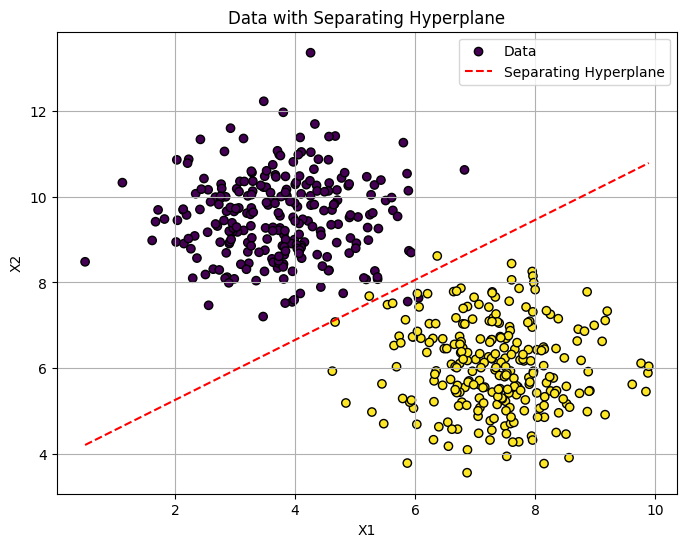

In [7]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

def find_separating_hyperplane(X, Y):
    n = X.shape[1]  # Dimension of the data
    N = X.shape[0]  # Number of data points

    # Define variables
    a = cp.Variable(n)
    b = cp.Variable()
    t = cp.Variable()

    # Define constraints
    constraints = [cp.multiply(Y, (X @ a - b)) >= t,
                   cp.norm(a, 2) <= 1,
                   t >= 0]

    # Define objective function
    objective = cp.Maximize(t)

    # Formulate the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    try:
        problem.solve()
    except cp.error.SolverError:
        # If solver fails, return None
        return None, None

    # Check if the problem is feasible
    if problem.status != cp.OPTIMAL:
        return None, None

    # Get the optimal values
    a_opt = a.value
    b_opt = b.value
    t_opt = t.value

    # Calculate the minimum distance
    min_distance = 1 / np.linalg.norm(a_opt)

    return (a_opt, b_opt), min_distance

def plot_data_with_hyperplane(X, y, hyperplane=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', edgecolors='k', label='Data')

    if hyperplane is not None:
        a_opt, b_opt = hyperplane
        x_values = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), num=100)
        y_values = (-a_opt[0] / a_opt[1]) * x_values + (b_opt / a_opt[1])
        plt.plot(x_values, y_values, color='red', linestyle='--', label='Separating Hyperplane')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Data with Separating Hyperplane')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate data
X, y = make_blobs(n_samples=500, centers=2, n_features=2, center_box=(0, 10), random_state=42)

# Assign labels {-1, 1}
y[y == 0] = -1

# Find separating hyperplane
hyperplane, min_distance = find_separating_hyperplane(X, y)

if hyperplane is not None:
    print("Separating Hyperplane Parameters:")
    print("a:", hyperplane[0])
    print("b:", hyperplane[1])
    print("Minimum Distance:", min_distance)
else:
    print("No separating hyperplane found.")

# Plot data with separating hyperplane
plot_data_with_hyperplane(X, y, hyperplane)


Separating Hyperplane Parameters:
a: [ 2.23280884e-14 -2.66601026e-13]
b: -6.606031265477912e-14
Minimum Distance: 3737837193842.915


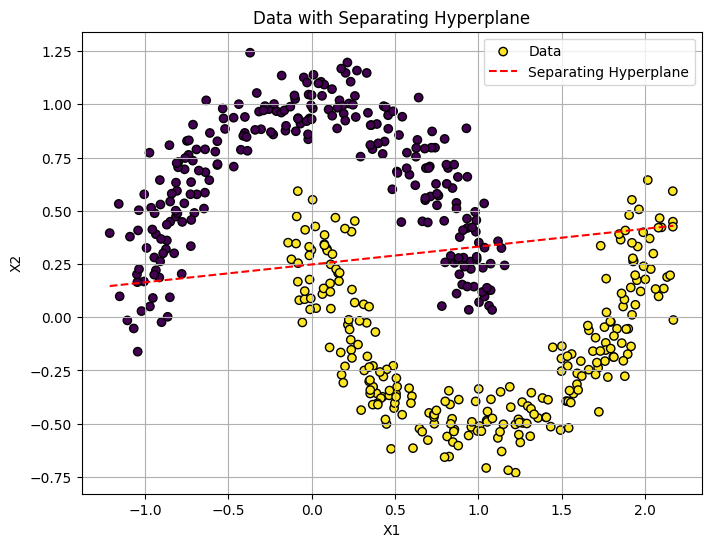

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
# Assign labels {-1, 1}
y[y == 0] = -1

# Find separating hyperplane
hyperplane, min_distance = find_separating_hyperplane(X, y)

if hyperplane is not None:
    print("Separating Hyperplane Parameters:")
    print("a:", hyperplane[0])
    print("b:", hyperplane[1])
    print("Minimum Distance:", min_distance)
else:
    print("No separating hyperplane found.")

# Plot data with separating hyperplane
plot_data_with_hyperplane(X, y, hyperplane)


## b)

In [8]:
import cvxpy as cp
import numpy as np

def solve_svm_optimization(X, Y, C):
    n = X.shape[1]  # Dimension of the data
    N = X.shape[0]  # Number of data points

    # Define variables
    a = cp.Variable(n)
    b = cp.Variable()
    ξ = cp.Variable(N)

    # Define constraints
    constraints = [Y[i] * (X[i] @ a - b) >= 1 - ξ[i] for i in range(N)]
    constraints += [ξ >= 0]

    # Define objective function
    objective = cp.Minimize(0.5 * cp.norm(a, 2)**2 + C * cp.sum(ξ))

    # Formulate the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    try:
        problem.solve()
    except cp.error.SolverError:
        # If solver fails, return None
        return None, None, None

    # Check if the problem is feasible
    if problem.status != cp.OPTIMAL:
        return None, None, None

    # Get the optimal values
    a_opt = a.value
    b_opt = b.value
    ξ_opt = ξ.value

    return a_opt, b_opt, ξ_opt

# Example usage:
# Generate some synthetic data
np.random.seed(42)
X = np.random.randn(100, 2)
Y = np.random.choice([-1, 1], 100)

# Set the value of C
C = 1.0

# Solve the optimization problem
a_opt, b_opt, ξ_opt = solve_svm_optimization(X, Y, C)

# Display the results
if a_opt is not None:
    print("Optimal values:")
    print("a:", a_opt)
    print("b:", b_opt)
    print("ξ:", ξ_opt)
else:
    print("Optimization failed.")


Optimal values:
a: [-0.6366957   0.49748621]
b: -0.19880106788854485
ξ: [ 1.18623928e+00  4.55893082e-01  1.23140561e+00  1.42488874e+00
  1.76762953e+00  1.26216299e+00  9.29141871e-02 -1.03417490e-11
  8.66138439e-11  1.07433447e+00  1.53308206e-01  1.55298643e+00
  1.60058967e+00 -4.69064055e-12  1.43611152e+00 -5.44623501e-12
  6.81198088e-01  1.93226262e+00  9.09096467e-02 -4.96952961e-12
  1.18612407e+00  1.12263889e+00  1.78205709e+00  2.82394899e-12
  1.02932611e-01  1.19911493e+00  1.93409491e+00  9.94332872e-01
  4.20701640e-01  5.26792683e-01  5.88473538e-01  6.91896518e-01
  6.43819911e-01  1.74389338e+00  6.47610783e-01  1.73385403e+00
 -2.05170188e-11 -4.46720859e-12  1.00537346e+00  1.84841076e+00
  1.51632379e+00  1.94523208e-11  5.36051745e-01  7.79517623e-01
  1.79144058e+00  3.81120262e-01  1.48278785e+00  1.27962387e+00
  1.14013396e+00  9.21158513e-01  1.09303719e-01  9.82115954e-01
  4.97499283e-01  8.47246748e-02  1.00221597e+00 -5.00321079e-12
 -5.28941400e-12  